# Object Detection with YOLOv5 on Bacalhau

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bacalhau-project/examples/blob/main/model-inference/object-detection-yolo5/index.ipynb)
[![Open In Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/bacalhau-project/examples/HEAD?labpath=model-inference/object-detection-yolo5/index.ipynb)

The identification and localization of objects in images and videos is a computer vision task called object detection. Several algorithms have emerged in the past few years to tackle the problem. One of the most popular algorithms to date for real-time object detection is [YOLO (You Only Look Once)](https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006), initially proposed by Redmond et al.[[1]](https://arxiv.org/abs/1506.02640)

Traditionally, models like YOLO required enormous amounts of training data to yield reasonable results. People might not have access to such high-quality labelled data. Thankfully, open source communities and researchers have made it possible to utilise pre-trained models to perform inference. In other words, you can use models that have already been trained on large datasets to perform object detection on your own data.

In this tutorial you will perform an end-to-end object detection inference, using the [YOLOv5 Docker Image developed by Ultralytics.](https://github.com/ultralytics/yolov5/wiki/Docker-Quickstart)

### Prerequisites

* You'll need the latest `bacalhau` client installed by following the [getting started instructions](../../../getting-started/installation).

In [ ]:
!command -v bacalhau >/dev/null 2>&1 || (export BACALHAU_INSTALL_DIR=.; curl -sL https://get.bacalhau.org/install.sh | bash)
path=!echo $PATH
pwd=!echo $PWD
%env PATH={pwd[-1]}:{path[-1]}

/Users/phil/.zshenv:.:1: no such file or directory: /Users/phil/.cargo/env
/Users/phil/.zshenv:.:2: no such file or directory: /Users/phil/source/bacalhau-project/examples/workload-onboarding/rust-wasm/./env
env: PATH=./:/Users/phil/.pyenv/versions/3.9.7/bin:/opt/homebrew/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/Users/phil/.gvm/bin:/opt/homebrew/opt/findutils/libexec/gnubin:/opt/homebrew/opt/coreutils/libexec/gnubin:/opt/homebrew/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/Users/phil/.pyenv/shims:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/usr/local/MacGPG2/bin:/Users/phil/.cargo/bin:/Users/phil/.nexustools


## 1. Running Object Detection Jobs on Bacalhau

Bacalhau is a highly scalable decentralised computing platform and is well suited to running massive object detection jobs. In this example, you can take advantage of the GPUs available on the Bacalhau network.

### Test Run with Sample Data

To get started, let's run a test job with a small sample dataset that is included in the YOLOv5 Docker Image. This will give you a chance to familiarise yourself with the process of running a job on Bacalhau.


In addition to the usual Bacalhau flags, you will also see:

* `--gpu 1` to specify the use of a GPU

:::tip
Remember that Bacalhau does not provide any network connectivity when running a job. All assets must be provided at submission time.
:::

The model requires pre-trained weights to run and by default downloads them from within the container. Bacalhau jobs don't have network access so we will pass in the weights at submission time, saving them to `/usr/src/app/yolov5s.pt`. You may also provide your own weights here.

The container has its own options that we must specify:

* `--input-urls` to select which pre-trained weights you desire with details on the [yolov5 release page](https://github.com/ultralytics/yolov5/releases)
* `--project` specifies the output volume that the model will save its results to. Bacalhau defaults to using `/outputs` as the output directory, so we save to there.

For more container flags refer to the [`yolov5/detect.py` file in the YOLO repository](https://github.com/ultralytics/yolov5/blob/master/detect.py#L3-#L25).

One final additional hack that we have to do is move the weights file to a location with the standard name. As of writing this, Bacalhau downloads the file to a UUID-named file, which the model is not expecting. This is because github 302 redirects the request to a random file in its backend.

In [7]:
%%bash --out job_id
bacalhau docker run \
--gpu 1 \
--timeout 3600 \
--wait-timeout-secs 3600 \
--wait \
--id-only \
--input-urls https://github.com/ultralytics/yolov5/releases/download/v6.2/yolov5s.pt \
ultralytics/yolov5:v6.2 \
-- /bin/bash -c 'find /inputs -type f -exec cp {} /outputs/yolov5s.pt \; ; python detect.py --weights /outputs/yolov5s.pt --source $(pwd)/data/images --project /outputs'

In [8]:
%env JOB_ID={job_id}

env: JOB_ID=b1e831bb-2ca0-4663-bc7b-fe3c3cd179d8



This should output a UUID (like `59c59bfb-4ef8-45ac-9f4b-f0e9afd26e70`). This is the ID of the job that was created. You can check the status of the job with the following command:


In [9]:
%%bash
bacalhau list --id-filter ${JOB_ID}

 CREATED   ID        JOB                      STATE      VERIFIED  PUBLISHED               
 15:53:15  b1e831bb  Docker ultralytics/y...  Completed            /ipfs/QmdPzJLDZeepW2... 



Where it says `Completed`, that means the job is done, and we can get the results. If it says `Error` you can debug the issue with the `bacalhau describe ${JOB_ID}` command.

In [10]:
%%bash
rm -rf results && mkdir results
bacalhau get ${JOB_ID} --output-dir results

Fetching results of job 'b1e831bb-2ca0-4663-bc7b-fe3c3cd179d8'...
Results for job 'b1e831bb-2ca0-4663-bc7b-fe3c3cd179d8' have been written to...
results


After the download has finished we can see the results:

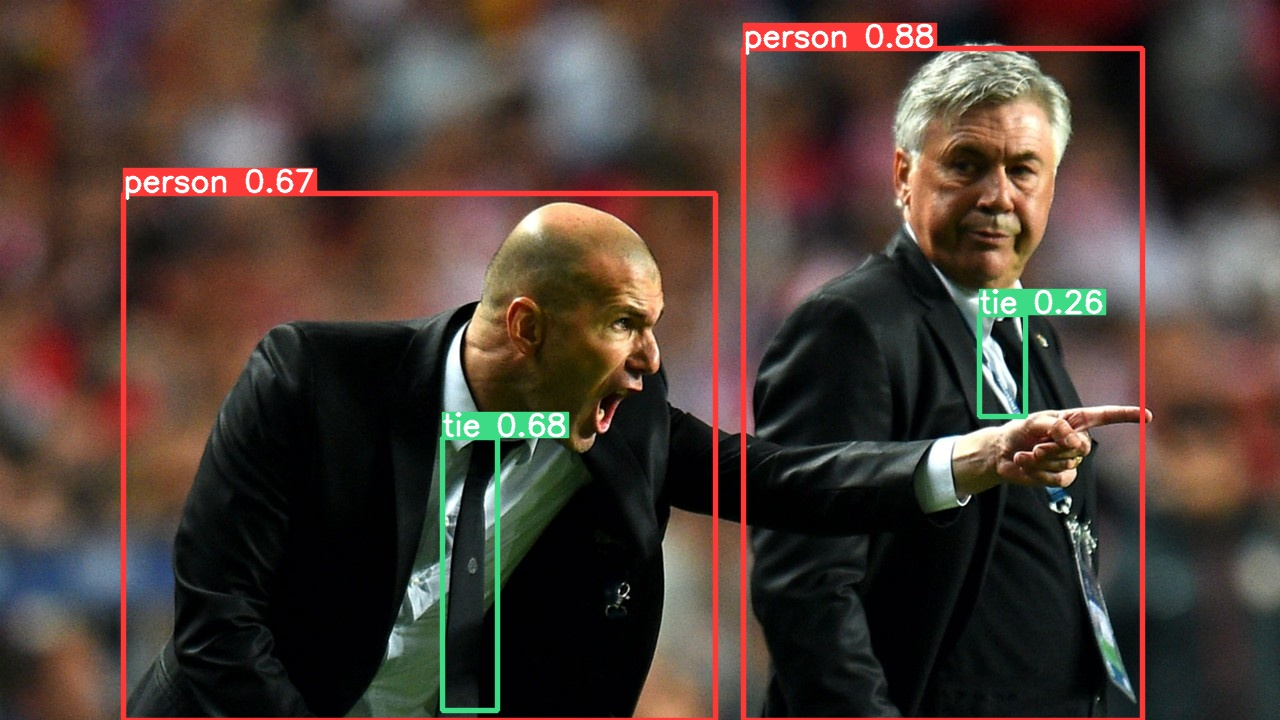

In [12]:
import IPython.display as display
display.Image("results/combined_results/outputs/exp/bus.jpg")
display.Image("results/combined_results/outputs/exp/zidane.jpg")

Football makes people angry!

## Using custom Images as an input

Now let's use some custom images. First you will need to ingest your images onto IPFS/Filecoin. For more information about how to do that see data ingestion section.

This example will use the [Cyclist Dataset for Object Detection | Kaggle](https://www.kaggle.com/datasets/f445f341fc5e3ab58757efa983a38d6dc709de82abd1444c8817785ecd42a1ac) dataset.

We have already uploaded this dataset to Filecoin under the CID: `bafybeicyuddgg4iliqzkx57twgshjluo2jtmlovovlx5lmgp5uoh3zrvpm`. You can browse to this dataset via [a HTTP IPFS proxy](https://w3s.link/ipfs/bafybeicyuddgg4iliqzkx57twgshjluo2jtmlovovlx5lmgp5uoh3zrvpm).

Let's run a the same job again, but this time use the images above.

In [14]:
%%bash --out job_id
bacalhau docker run \
--gpu 1 \
--timeout 3600 \
--wait-timeout-secs 3600 \
--wait \
--id-only \
--input-urls https://github.com/ultralytics/yolov5/releases/download/v6.2/yolov5s.pt \
--input-volumes bafybeicyuddgg4iliqzkx57twgshjluo2jtmlovovlx5lmgp5uoh3zrvpm:/datasets \
ultralytics/yolov5:v6.2 \
-- /bin/bash -c 'find /inputs -type f -exec cp {} /outputs/yolov5s.pt \; ; python detect.py --weights /outputs/yolov5s.pt --source /datasets --project /outputs'

In [15]:
%env JOB_ID={job_id}

env: JOB_ID=7e2c5c13-40e6-473d-a76b-229416c3c04e


In [16]:
%%bash
bacalhau list --id-filter ${JOB_ID}

 CREATED   ID        JOB                      STATE      VERIFIED  PUBLISHED               
 16:03:34  7e2c5c13  Docker ultralytics/y...  Completed            /ipfs/QmYbEH1wkfq9RM... 


In [17]:
%%bash
rm -rf custom-results && mkdir custom-results
bacalhau get ${JOB_ID} --output-dir custom-results

Fetching results of job '7e2c5c13-40e6-473d-a76b-229416c3c04e'...
Results for job '7e2c5c13-40e6-473d-a76b-229416c3c04e' have been written to...
custom-results


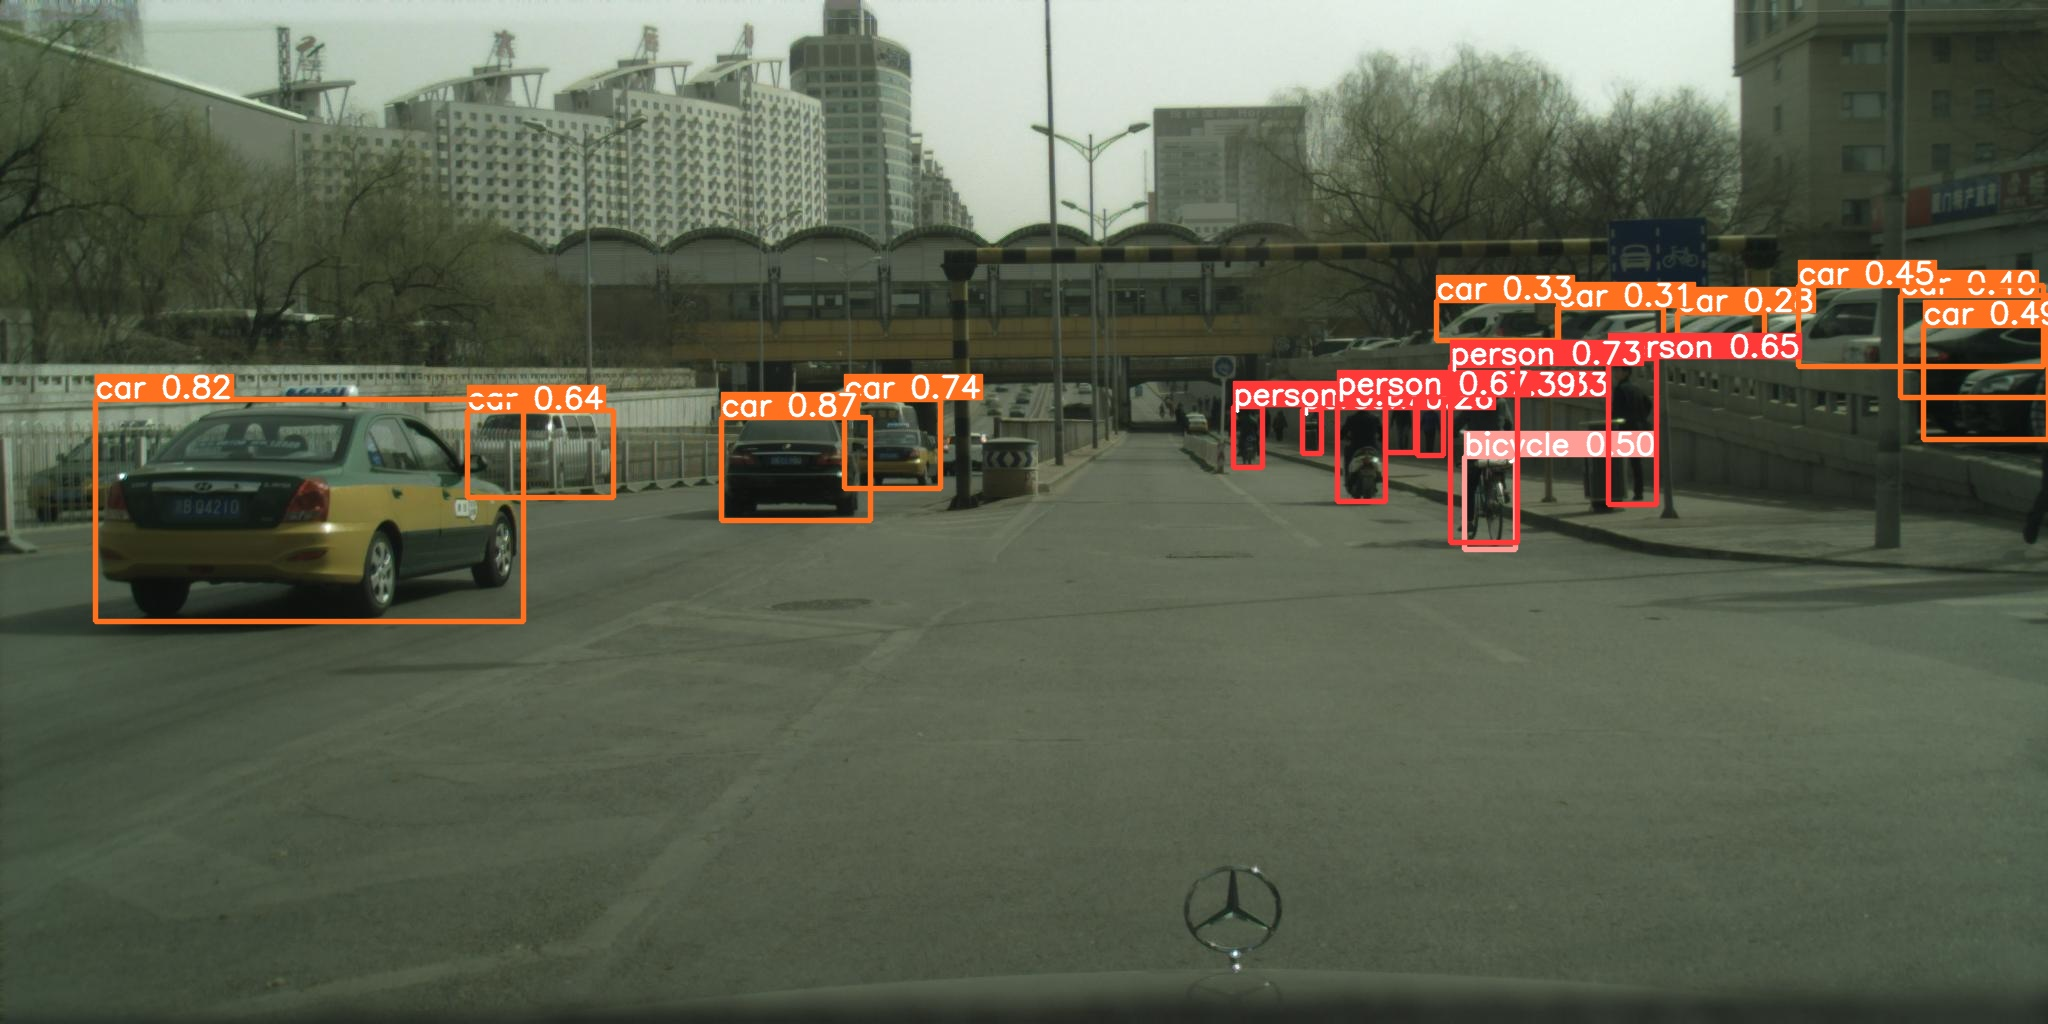

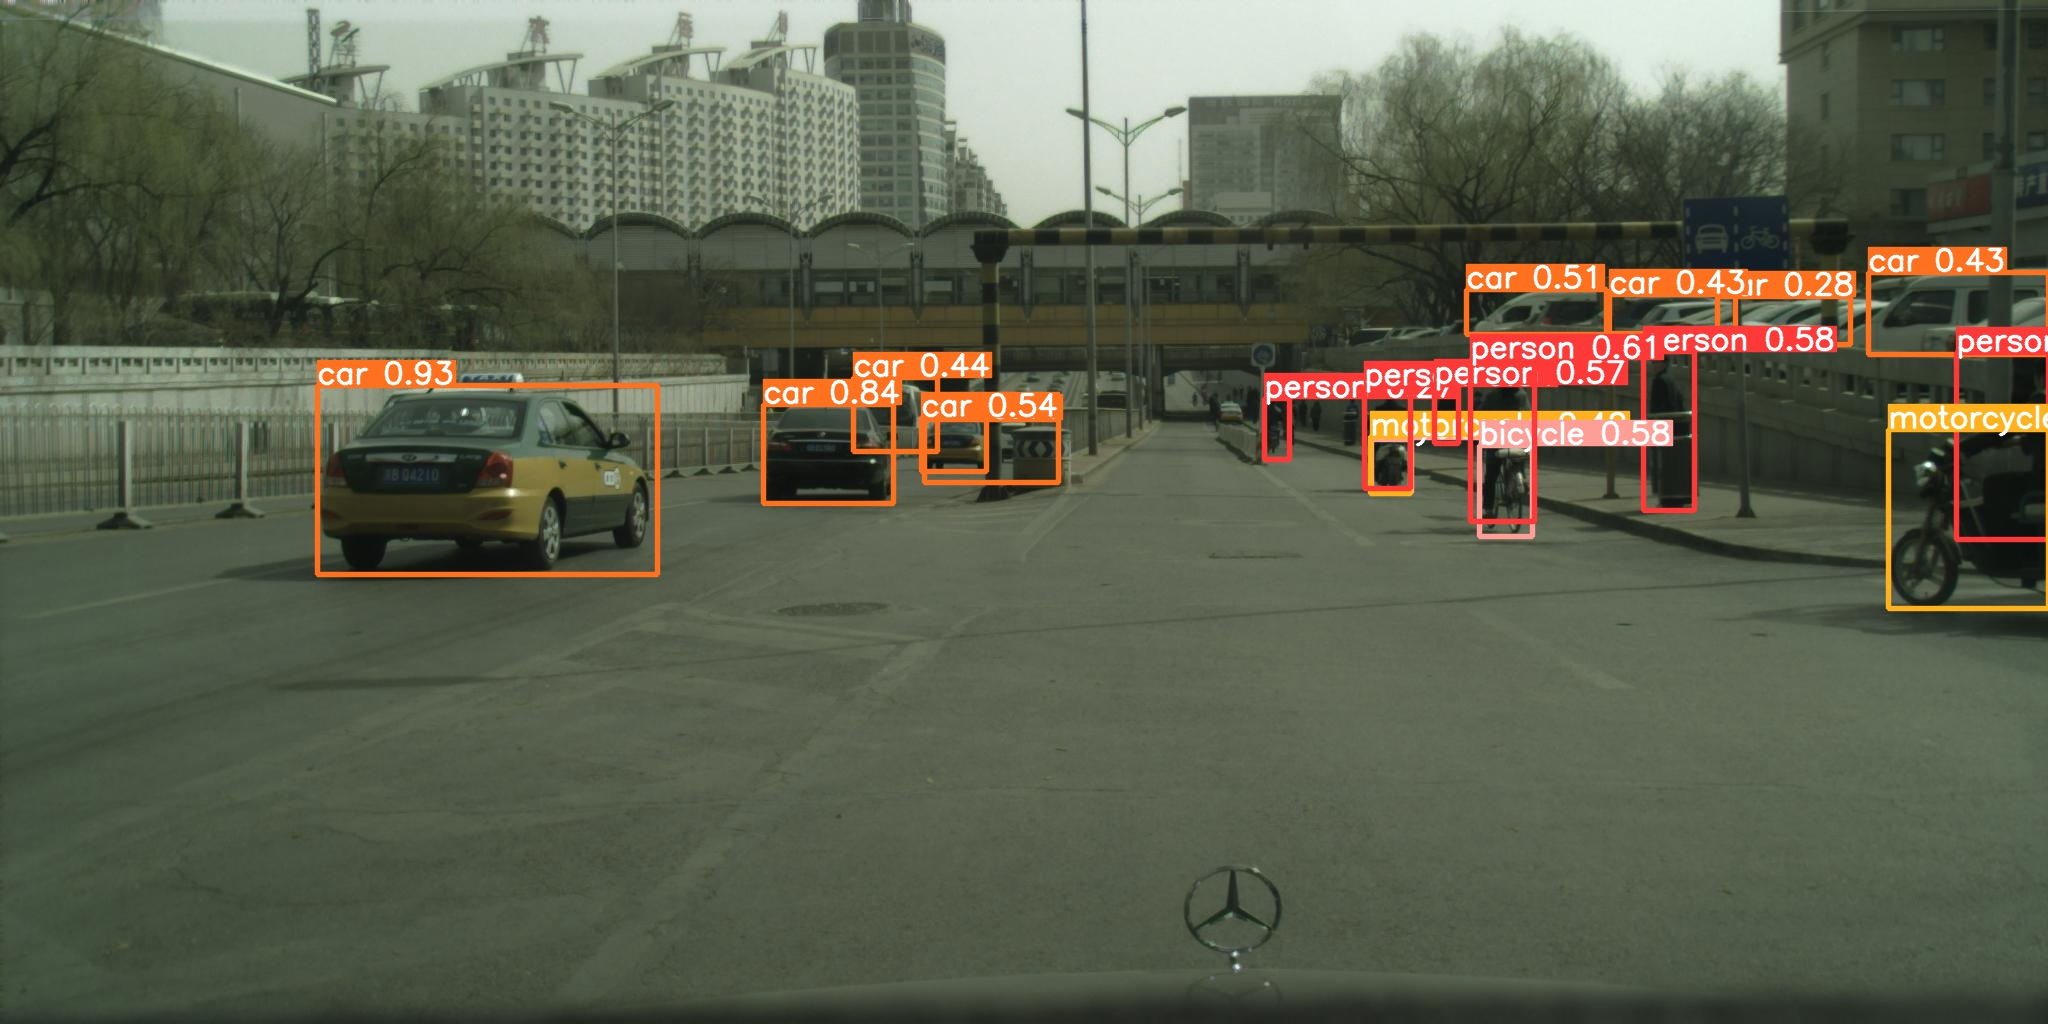

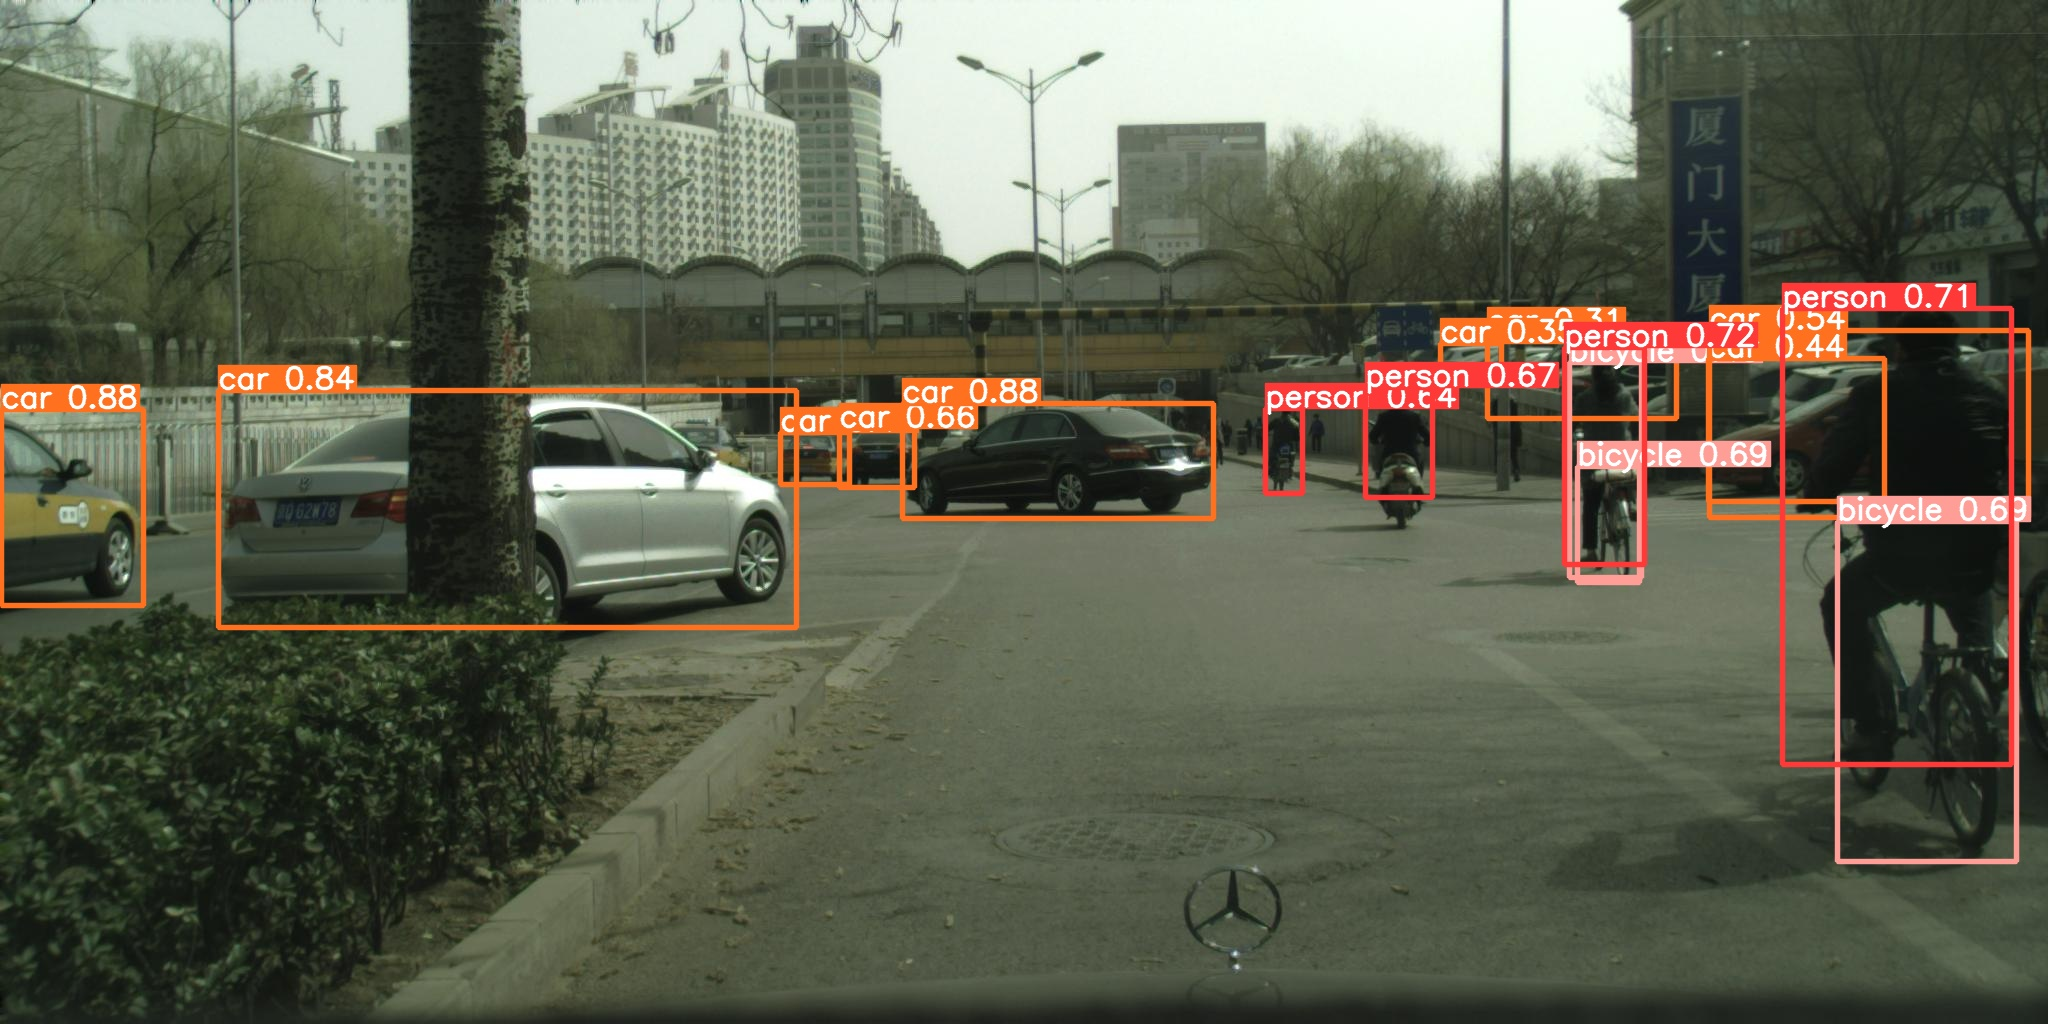

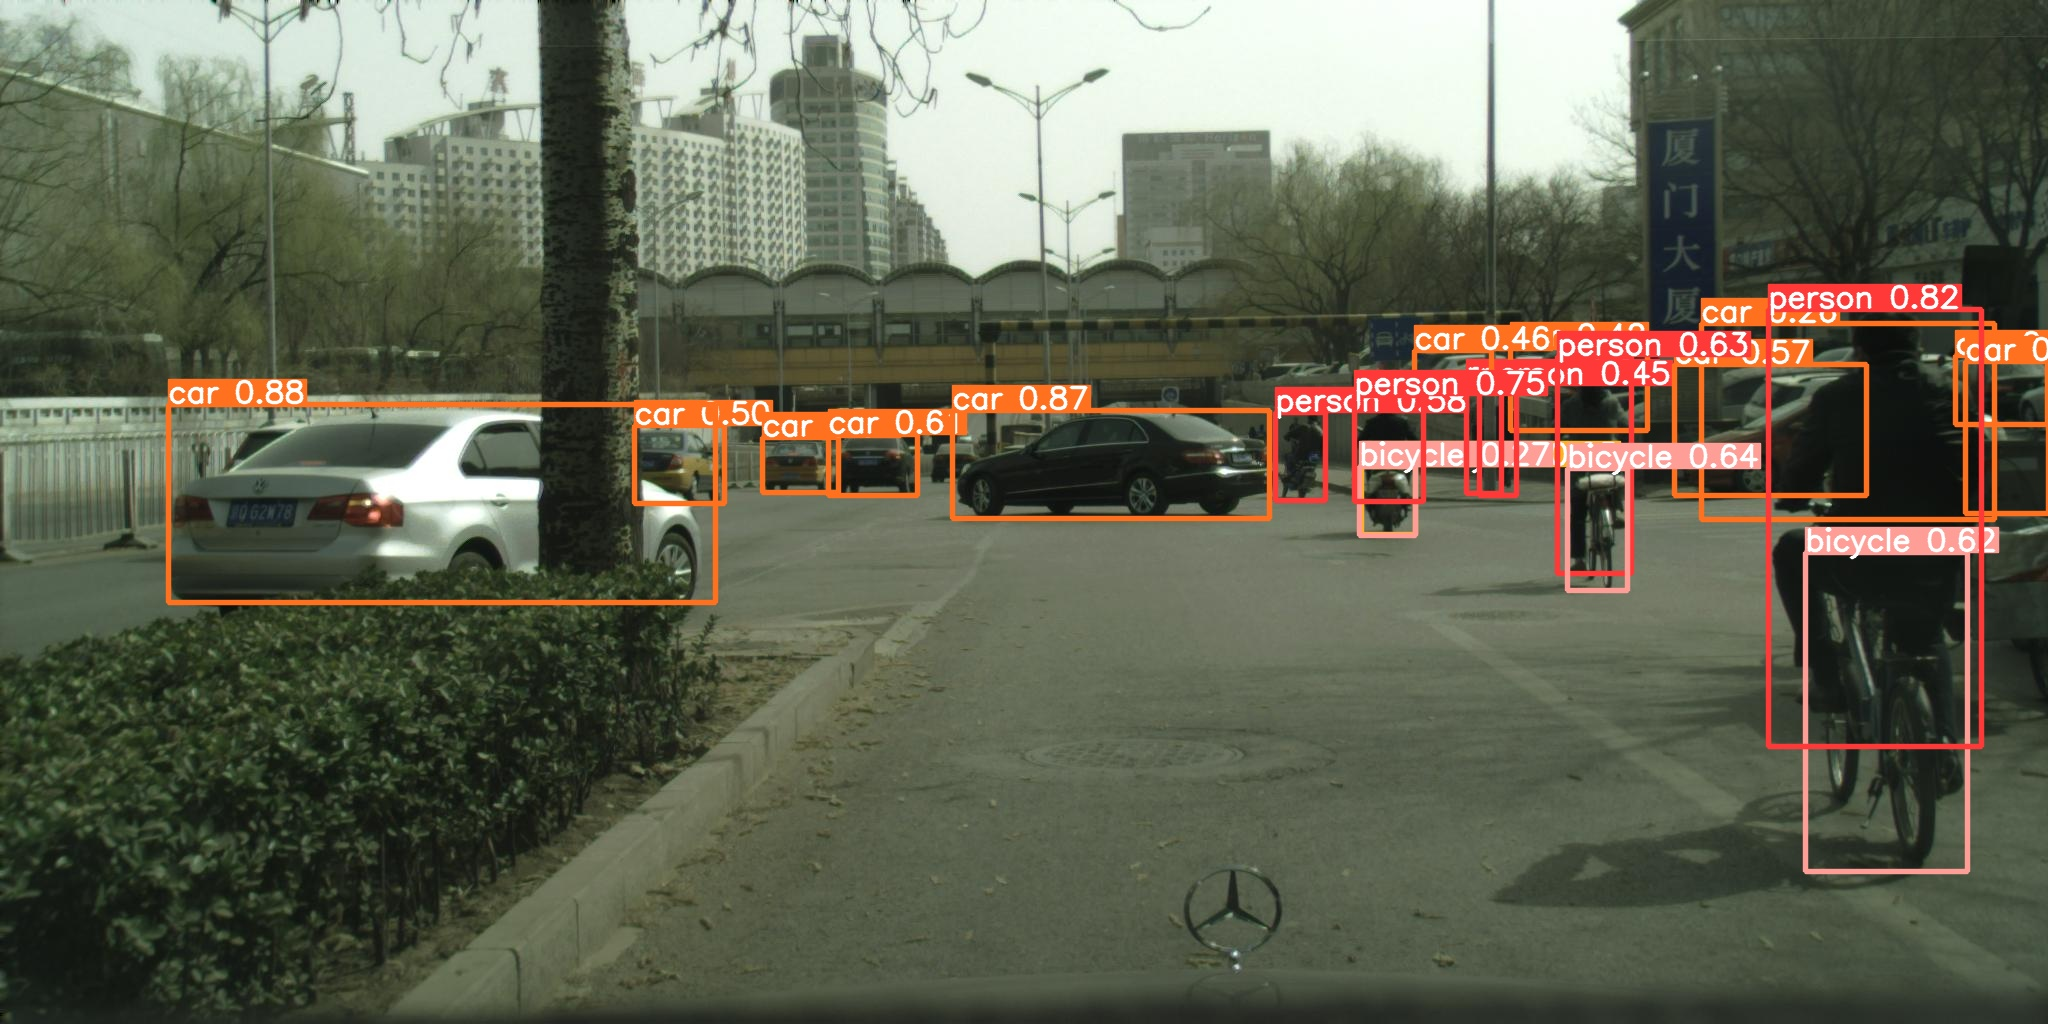

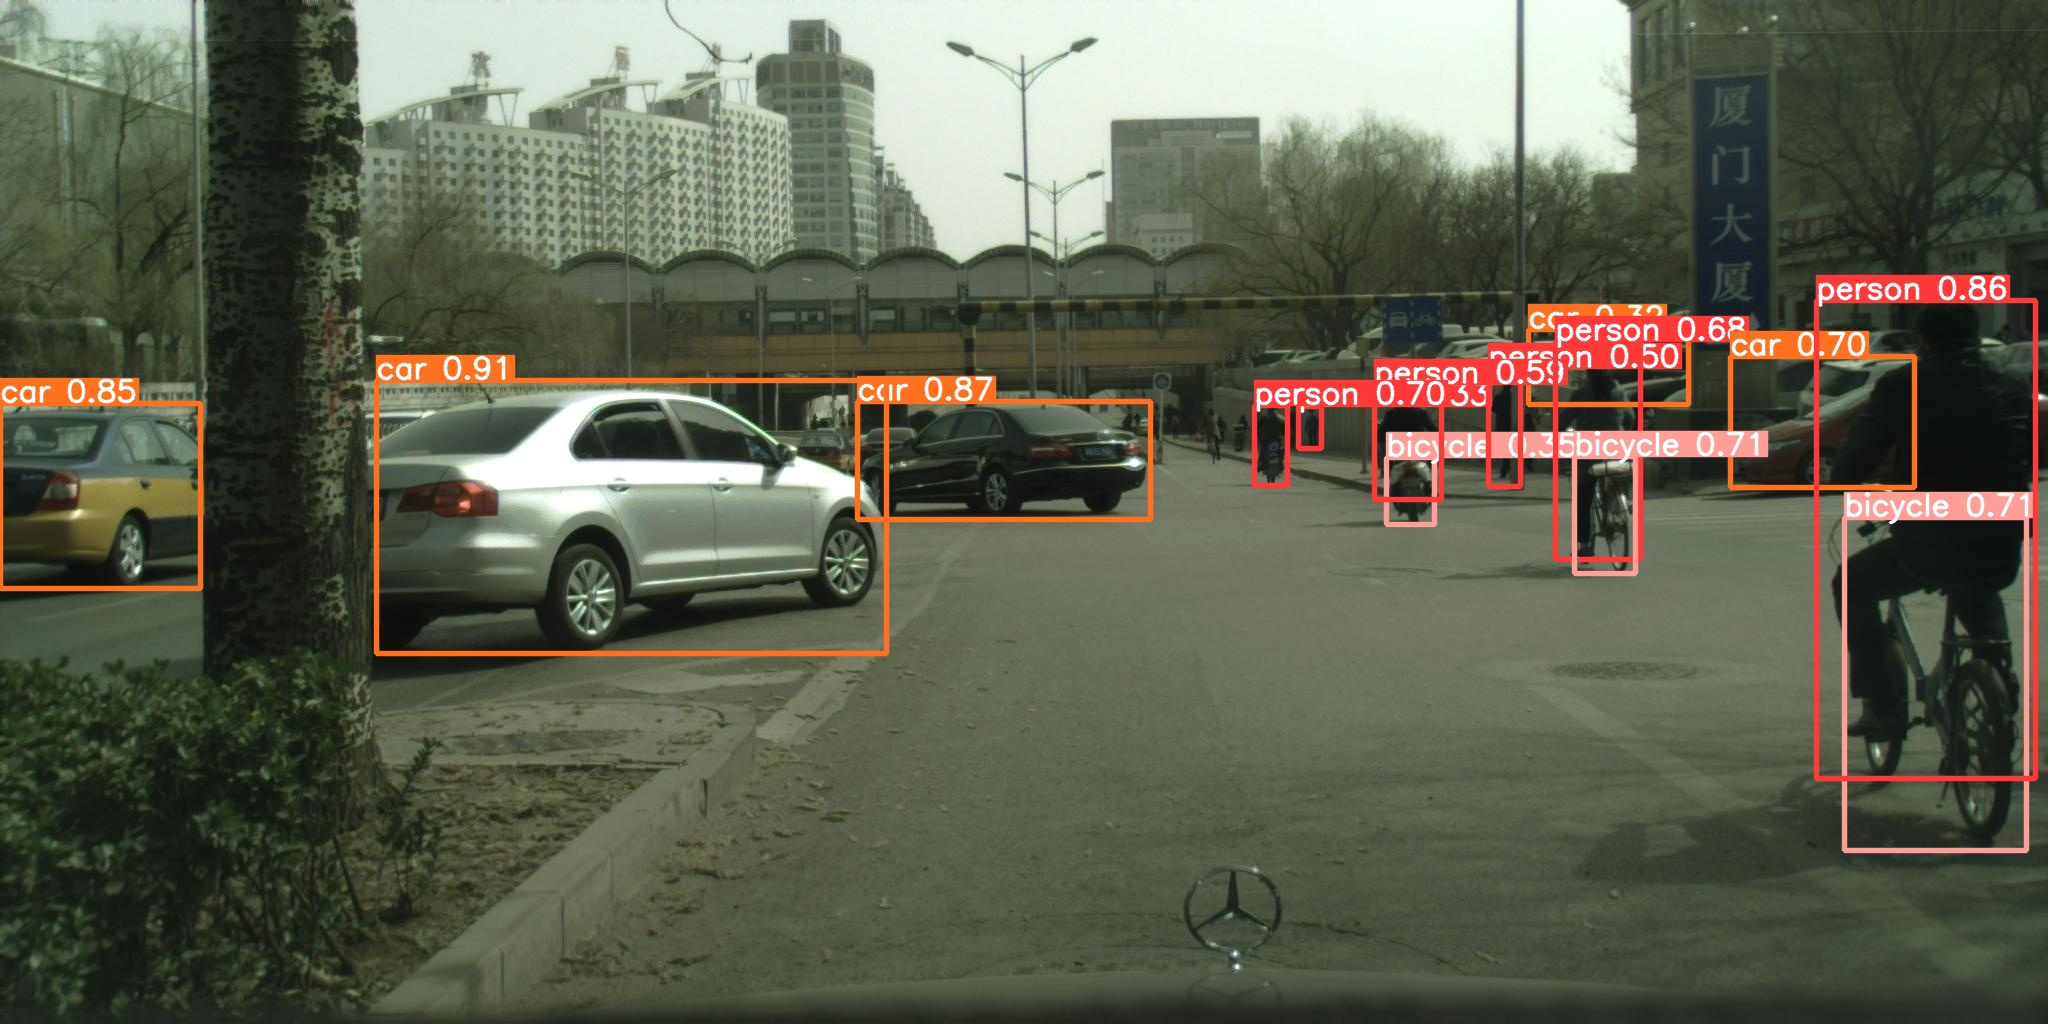

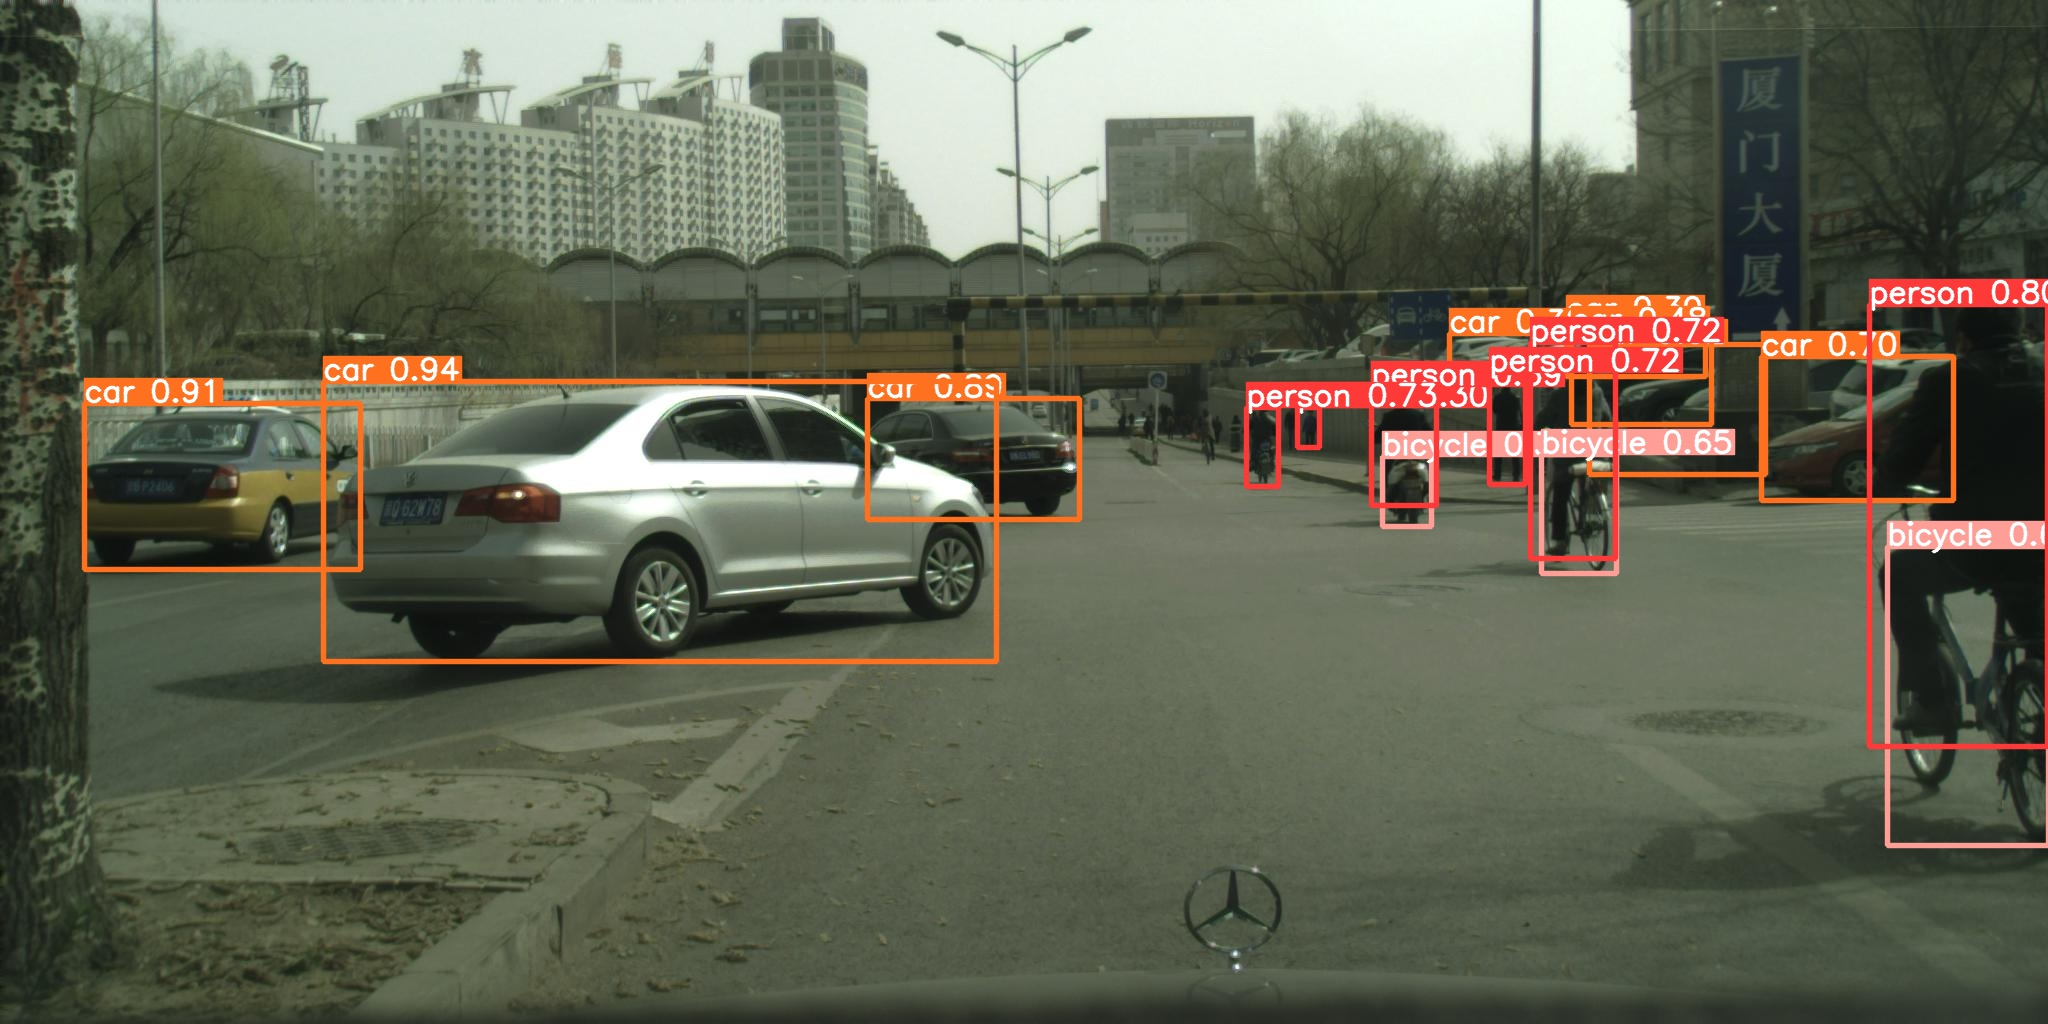

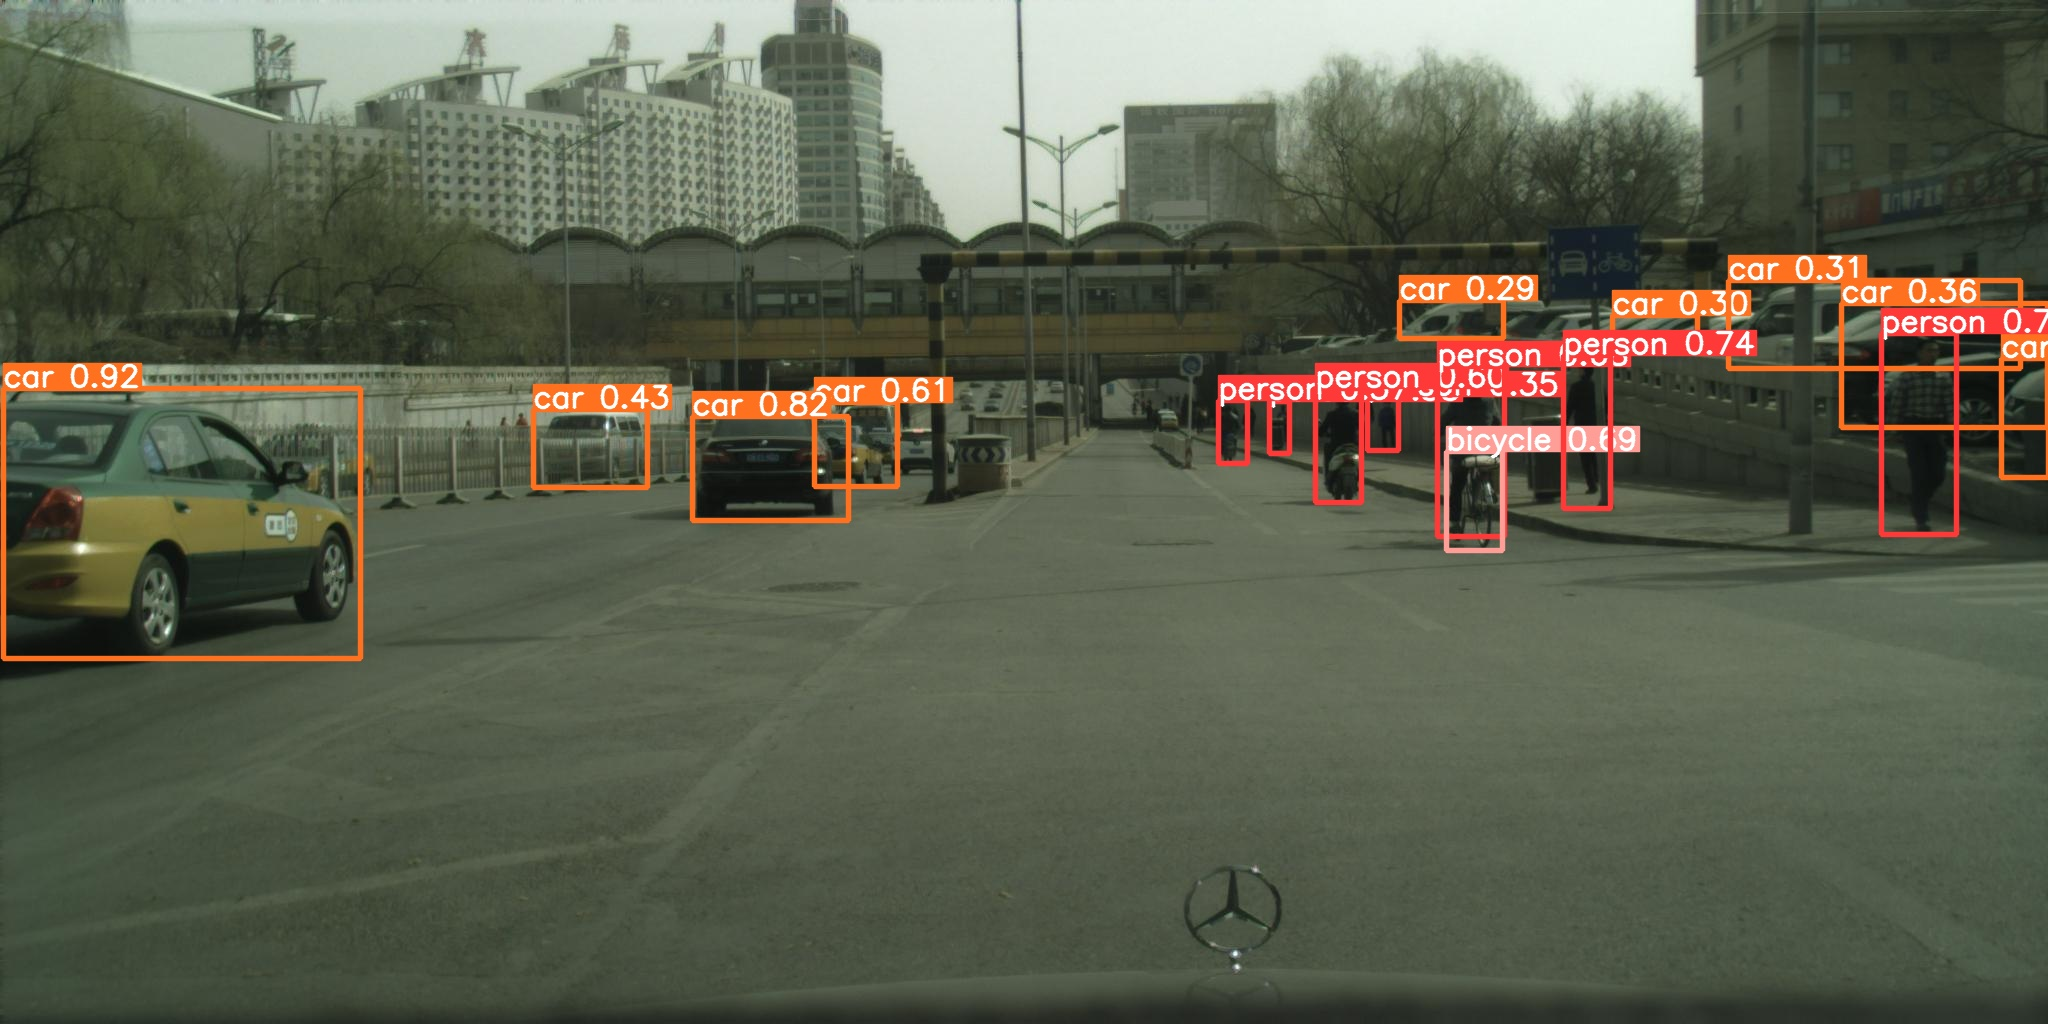

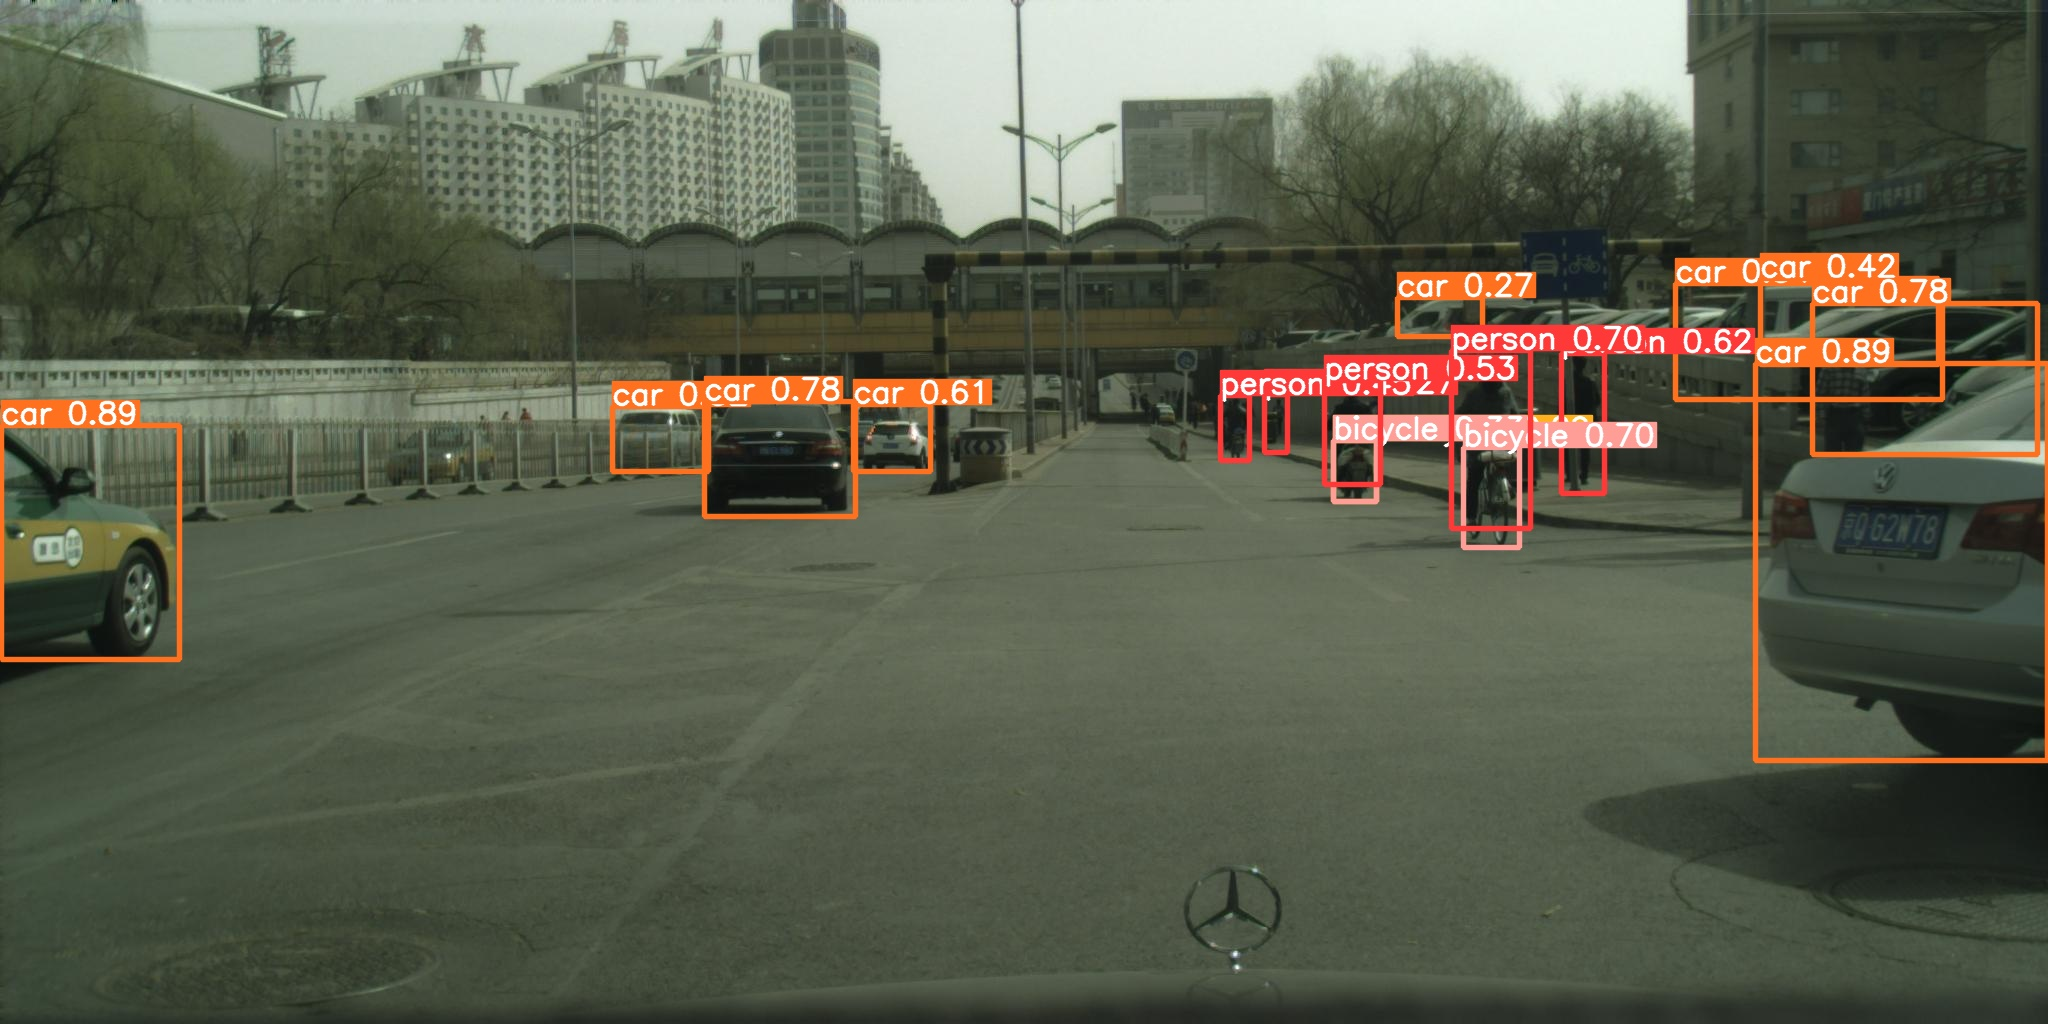

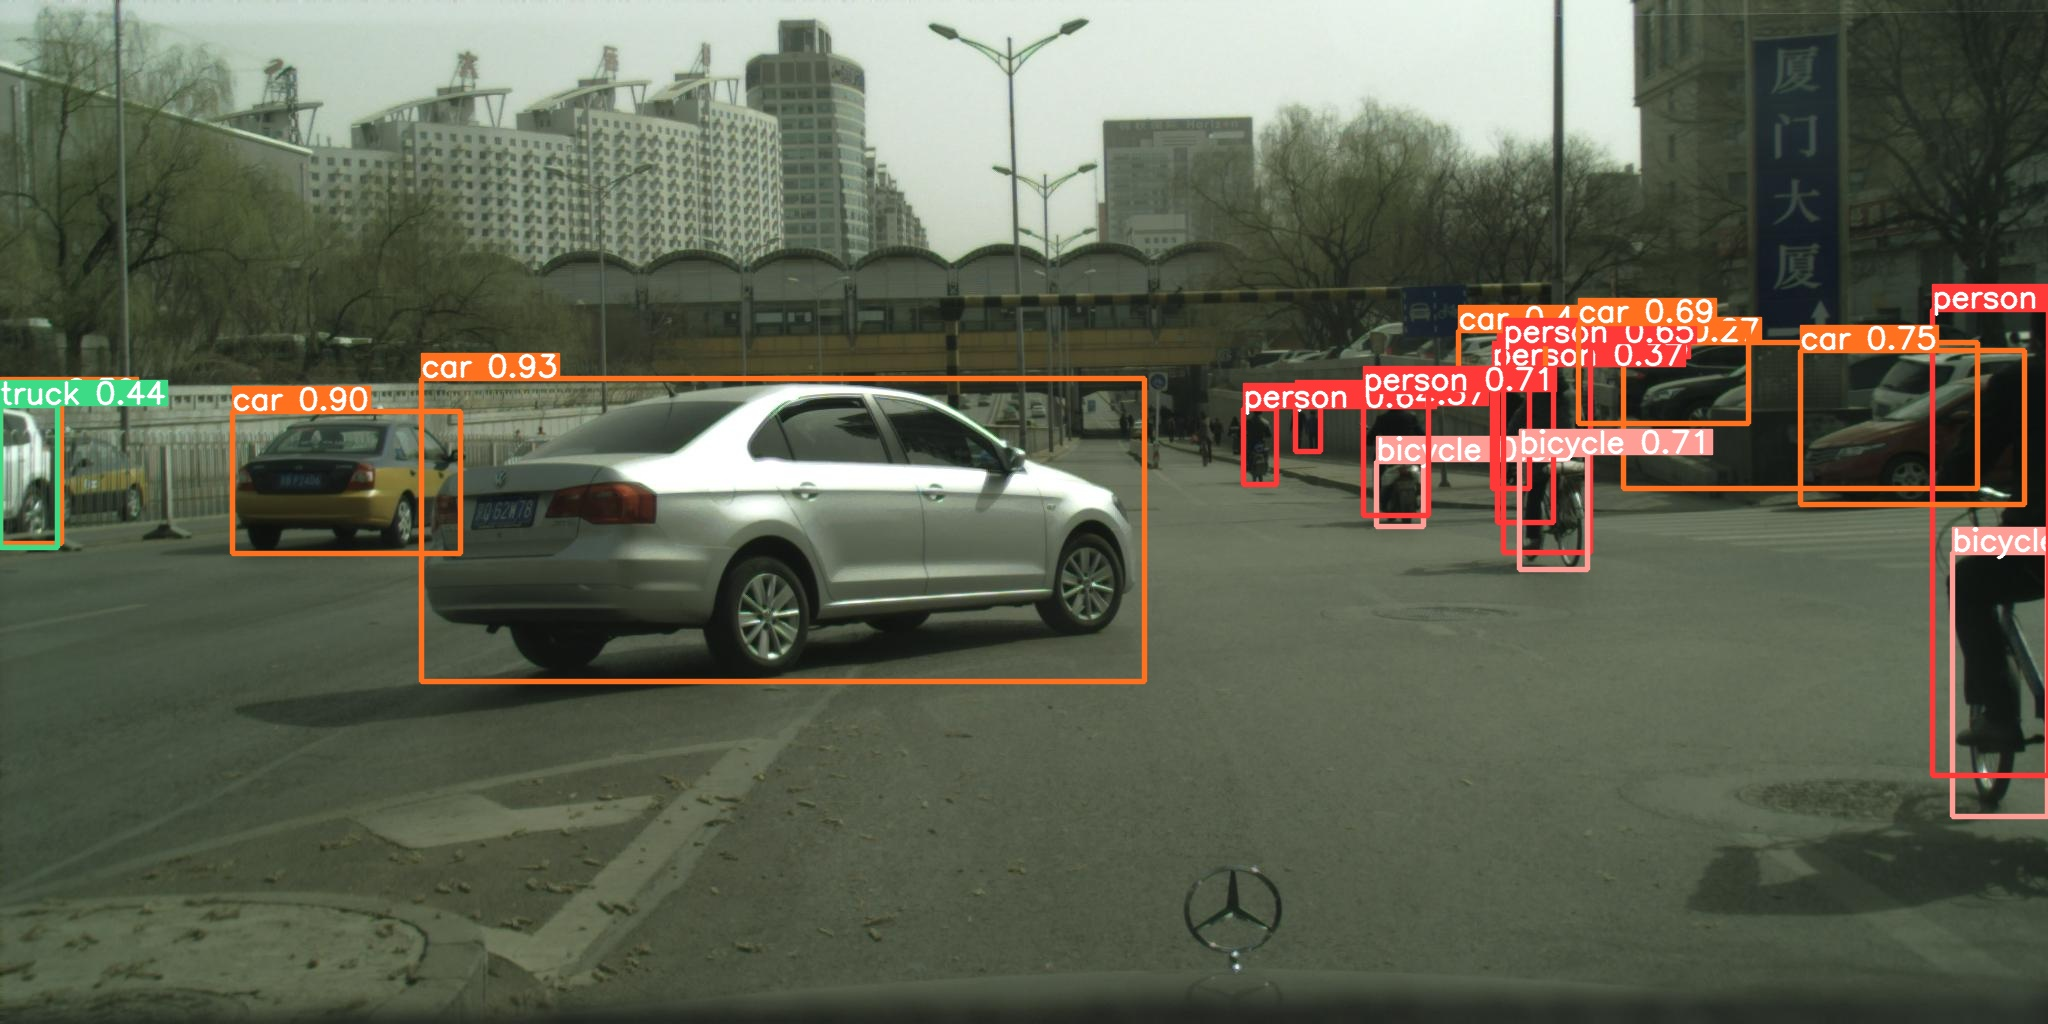

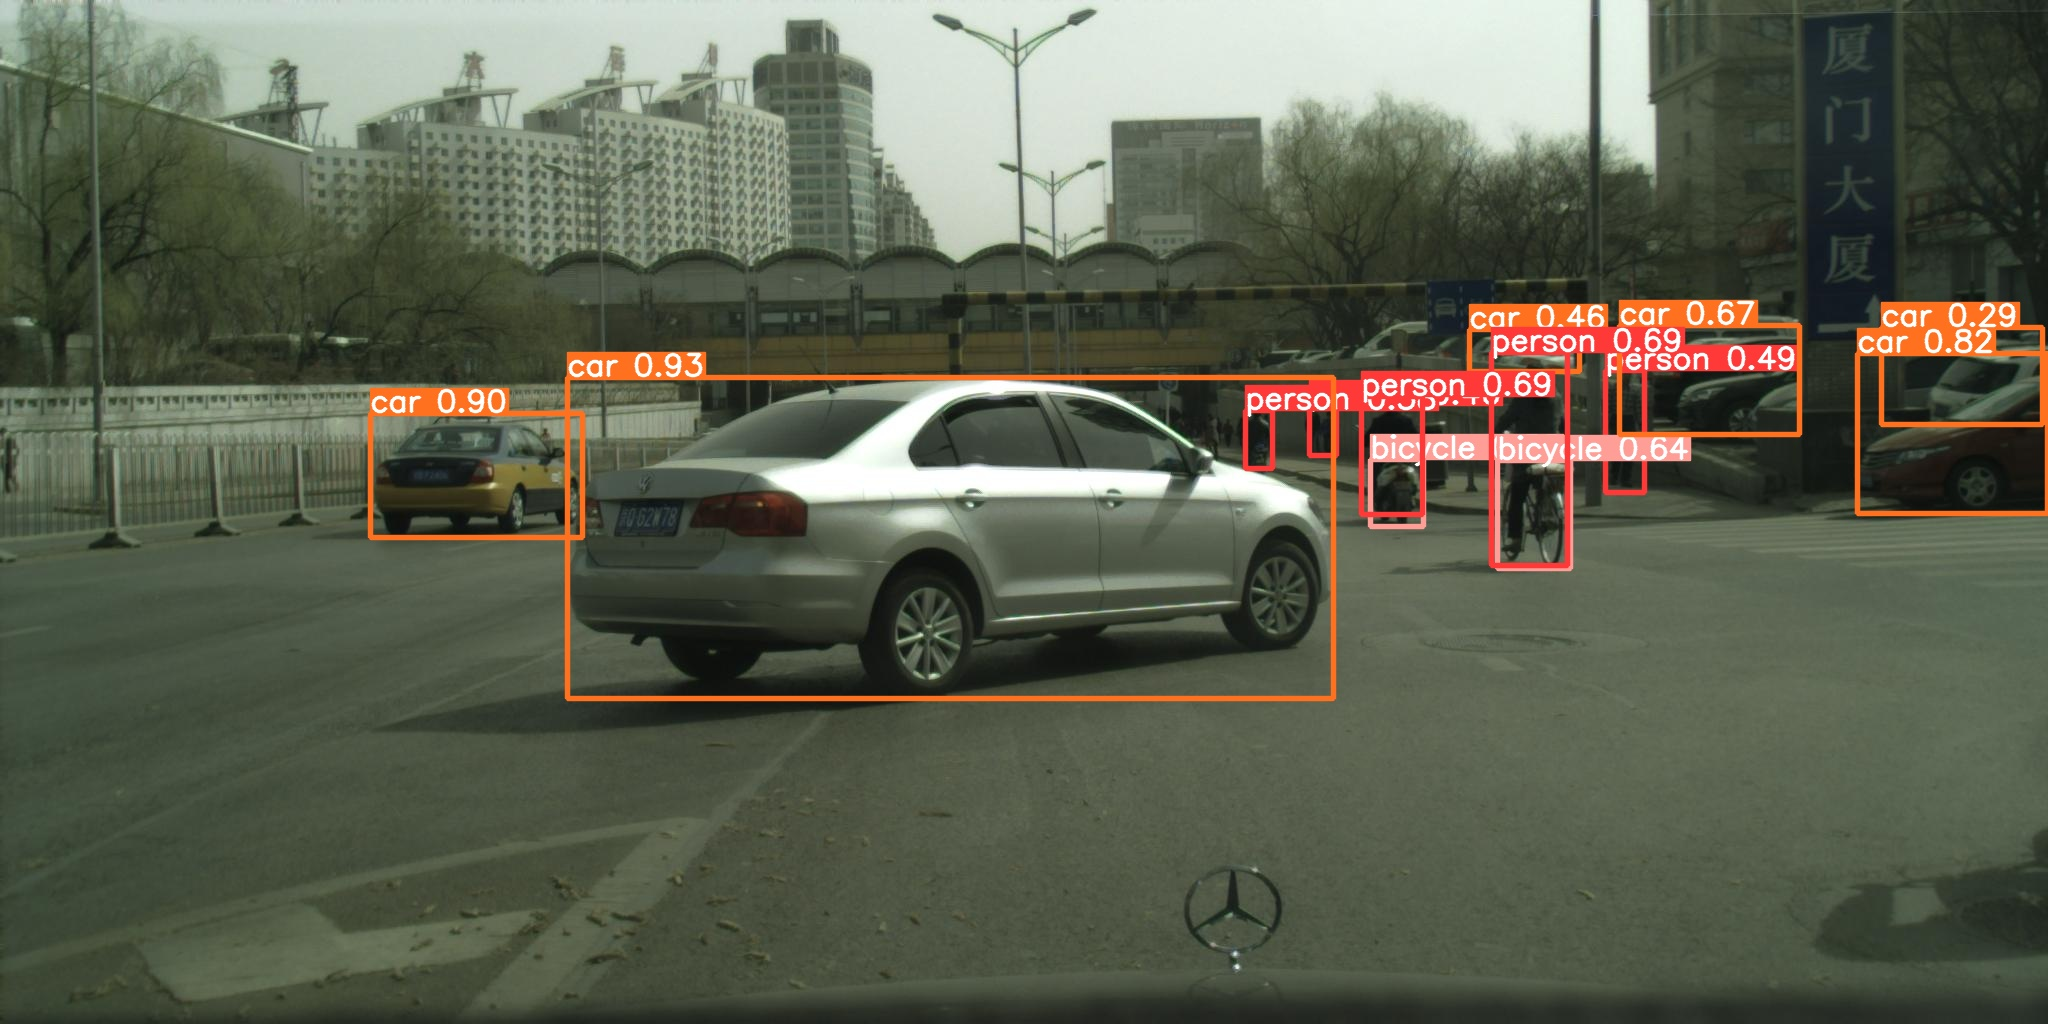

In [22]:
import glob
from IPython.display import Image, display
for file in glob.glob('custom-results/combined_results/outputs/exp/*.jpg'):
    display(Image(filename=file))